In [1]:
import pandas as pd
import openpyxl
import xlsxwriter
import numpy as np
import pdb
from dateutil.relativedelta import *
import glob
import matplotlib.pyplot as plt

In [2]:
#Converting xls data
shortlisted_companies_df  = pd.DataFrame() 
for input_file  in glob.glob('../../finance_vicky/files/output/backtest/*.xlsx'):
    xl = pd.ExcelFile(input_file)
    if 'Shortlisted Companies' in xl.sheet_names:
        script_df = xl.parse('Shortlisted Companies')
        shortlisted_companies_df = pd.concat([shortlisted_companies_df, script_df])       
shortlisted_companies_df.reset_index(inplace = True)

shortlisted_companies_df.set_index(['Start Date', 'Script Name'], inplace=True)
shortlisted_companies_df.sort_index(level='Start Date', inplace=True)

In [17]:

print(shortlisted_companies_df.head())
simulated_df = pd.DataFrame()
capital_df = pd.DataFrame()
capital = 10000000
capital_count = 1

#distribute the money equally across all scripts.
for i, data in shortlisted_companies_df.groupby(level = 0):
    sc_df = pd.DataFrame()
    sc_df = pd.concat([sc_df,data.loc[(i)]])
    total_scripts = len(sc_df.index)
    share_per_script = capital/total_scripts 
    if share_per_script > 100:
        for script in sc_df.index.values:
            shares = np.floor(share_per_script/sc_df.loc[script, 'Open for Test Data'])
            sc_df.loc[script, 'No. of Shares'] = shares
            net_pl = shares * sc_df.loc[script, 'Net for Test Data']
            sc_df.loc[script, 'Investment'] = shares * sc_df.loc[script, 'Open for Test Data']
            sc_df.loc[script, 'Balance'] = share_per_script - shares * sc_df.loc[script, 'Open for Test Data']
            sc_df.loc[script, 'Disinvestment'] = shares * sc_df.loc[script, 'Close for Test Data']
            sc_df.loc[script,'net_pl'] = net_pl
            sc_df.loc[script, 'Start Date'] = i
            capital += sc_df.loc[script, 'net_pl']
            capital += sc_df.loc[script, 'Balance']         
        sc_df.reset_index(inplace=True)
        simulated_df = pd.concat([simulated_df, sc_df])
     
        
        df = pd.DataFrame.from_records([{'Invest Date': i, 'Investment': sc_df['Investment'].sum(), 'Gains/Loss' : sc_df['net_pl'].sum(),
                      'Disinvestment': sc_df['Disinvestment'].sum(), 'Balance': sc_df['Balance'].sum(),
                      'Total Funds': sc_df['Disinvestment'].sum() + sc_df['Balance'].sum(), 
                      'Disinvest Date': sc_df['End Date'][0]}], index='Invest Date')
        
        capital_df = pd.concat([capital_df, df])            
    else: 
        capital += 10000000
        capital_count += 1
print(capital, capital_count)
print(shortlisted_companies_df['Investment'])
print(capital_df.head())
#print(simulated_df.columns)
#simulated_df.set_index(['Start Date', 'Script Name'], inplace=True)
#simulated_df.sort_index(level='Start Date', inplace=True)
#print(simulated_df.head())

                             index  Positive  Negative    Net     Open  \
Start Date Script Name                                                   
2007-04-03 Aban Offshore         2    175.98   -100.18  74.07  1139.35   
           Aditya Bir. Nuv.      3    131.41    -90.66  40.98   348.31   
           BF Utilities          1    193.21    -99.07  91.04  1092.85   
           Centurion BnkP        5    134.80    -91.26  41.23    25.75   
           Guj.St.Petronet       8    139.57   -101.86  37.83    37.10   

                               Close  Market Cap      P/YR  \
Start Date Script Name                                       
2007-04-03 Aban Offshore     2052.45     4204.20  2.247782   
           Aditya Bir. Nuv.   489.08     4484.41  3.474320   
           BF Utilities      2125.45     4115.67  2.058348   
           Centurion BnkP      35.60     3626.37  3.614213   
           Guj.St.Petronet     48.55     2011.71  4.240175   

                             Open for Test Dat

In [18]:

output_file = '../../finance_vicky/files/output/backtest/simulation_details.xlsx'
writer = pd.ExcelWriter(output_file, engine='xlsxwriter', datetime_format='mm/dd/yy', date_format='mm/dd/yy')
#pdb.set_trace()
simulated_df.set_index(['Start Date', 'Script Name'], inplace = True)
simulated_df.sort_index(level='Start Date', inplace=True)
simulated_df.to_excel(writer,sheet_name='Sheet') 
capital_df.to_excel(writer, sheet_name='Capital Gains')
writer.save()

In [19]:
#capital_df.head()
capital_df.dropna(inplace=True)
if 'index' in capital_df.columns:
    capital_df.drop(['index'], axis=1, inplace=True)
capital_df.sort_index(inplace=True)
#capital_df.head(39)


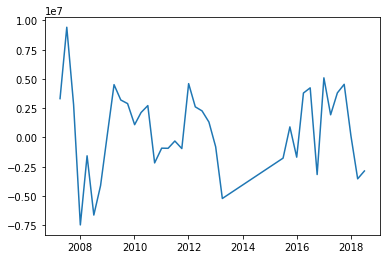

            index    Positive    Negative         Net         Open  \
count  456.000000  456.000000  456.000000  456.000000   456.000000   
mean     5.857456  127.234474  -60.664561   66.609474   398.122917   
std      4.174158   41.739322   46.934624   42.930689   807.406742   
min      0.000000   47.210000 -240.820000  -87.690000     7.750000   
25%      2.750000   97.095000  -79.445000   43.985000    75.200000   
50%      5.500000  115.500000  -53.220000   63.495000   157.875000   
75%      8.250000  148.147500  -30.777500   90.400000   332.012500   
max     21.000000  287.390000   52.710000  230.750000  6893.300000   

              Close   Market Cap        P/YR  Open for Test Data  \
count    456.000000   456.000000  456.000000          456.000000   
mean     725.206535  3131.497281    3.275377          728.207368   
std     1540.884418   806.938827   21.284972         1550.778909   
min       19.750000  2005.390000  -65.129676           19.750000   
25%      129.317500  2462.452

In [24]:
plt.plot(capital_df['Gains/Loss'])
plt.show()